In [1]:
# import PyPDF2
# import spacy
import numpy as np
import pandas as pd
import fitz
import nltk

from nltk.tokenize import sent_tokenize
# from pathlib import Path

import os

# nlp = spacy.load('en_core_web_lg')

In [4]:
# sent_list = []

# for page in pdf_text[2:]:
#     doc = nlp(page)
#     for sentence in doc.sents:
#         sent_list.append(sentence)

In [20]:
path_pdf = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data\\reports'
fname_out = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data_structured\\report_sentences.csv'

In [3]:
def get_cnt(text):
    cnt = 0
    for word in text.split():
        if word.isalnum():
            cnt += 1
    return cnt

In [4]:
def get_text(block_lst):

    MIN_WORD_CNT = 6
    
    text_lst = []
    for block in block_lst:
        if block[6] != 0: continue # block_type: 0 = text
        
        #I'm replacing the non-ascii single quotation mark here, because it's used in Coca Cola's report
        text = block[4].replace('’',"'")
        text = ''.join([i if ord(i) < 128 else ' ' for i in text])
        #text = text.replace('fi ', 'fi') # PyMuPDF(fitz) bug fix: 'fi ' --> 'fi'
    
        if get_cnt(text) < MIN_WORD_CNT: continue # Delete sentences with less than MIN_WORD_CNT(10) 
    
        text_lst.append(text.replace('-\n', ''))
        #.replace('-\n', '')
    return ('\n'.join(text_lst))

In [8]:
# test_sent = sent_tokenize(text)[2]

# r_sent = ' '.join(test_sent.split()) #split splits the words of the sentence into a list - and gets rid of /n etc.

# ' '.join(test_sent.split()) #joins the items of the list with a space 

In [5]:
def get_sentence(fname, skip_page = (0,)):
 
    doc = fitz.open(fname)
    
    sent_lst = []
    for page_no, page in enumerate(doc):

        # Skip page
        if page_no in skip_page: continue
        
        block_lst = page.get_text_blocks()
        text = get_text(block_lst)
    
        for i, sentence in enumerate(sent_tokenize(text)):
            r_sent = ' '.join(sentence.split()) # Delete '\n', '\t' and strip
            sent_lst.append(r_sent)
            
    doc.close()

    return sent_lst

In [6]:
def gen_document(fname, sent_lst):

    res_df = pd.DataFrame(
        {
            'doc_type': 'report',
            'fname': fname.split('.')[0],
            'sentence': sent_lst
        }
    )
    
    return res_df

In [7]:
def read_filelist(path):

    # Create empty DataFrame
    df = pd.DataFrame()
    
    # Read file list (directory)
    for idx, fname in enumerate(os.listdir(path)):
        p_fname = os.path.join(path, fname)
        print('path + fname >>>', p_fname)
        
        if p_fname.split('.')[-1] != 'pdf': continue
        print('fname >>>',fname)
    
#         doc_id = int(idx)
        
#         print(f'doc_id = [{doc_id}], fname = [{fname}]')
#         print('')
    
        sent_lst = get_sentence(p_fname)
        df_doc   = gen_document(fname, sent_lst)
        
        df = pd.concat([df,df_doc])
        
    return df

In [8]:
%%time
df = read_filelist(path_pdf)
print('==== End of jobs ====')

path + fname >>> data/reports\coca-cola.pdf
fname >>> coca-cola.pdf
path + fname >>> data/reports\nestle.pdf
fname >>> nestle.pdf
path + fname >>> data/reports\pepsico.pdf
fname >>> pepsico.pdf
path + fname >>> data/reports\procter-gamble.pdf
fname >>> procter-gamble.pdf
path + fname >>> data/reports\unilever.pdf
fname >>> unilever.pdf
==== End of jobs ====
CPU times: total: 18.9 s
Wall time: 20.4 s


In [157]:
df['sentence'].values[1507]

'Our goal is 100% renewable electricity at all our sites by 2025.'

In [ ]:
df.to_csv(fname_out, index = False)

In [39]:
df.values[14]

array([0, 'coca-cola.pdf',
       'In 2021, we returned 167% of the water used in our finished beverages to nature and communities.'],
      dtype=object)

In [9]:
df

,doc_type,fname,sentence
0,report,coca-cola,The Coca-Cola Company 2021 Business & ESG Repo...
1,report,coca-cola,We do all of this while staying true to our pu...
2,report,coca-cola,The Coca-Cola Company 2021 Business & ESG Repo...
3,report,coca-cola,We made important decisions about streamlining...
4,report,coca-cola,"Through all of the challenges, initiatives and..."
...,...,...,...
4302,report,unilever,Pureprint is a CarbonNeutral company.
4303,report,unilever,Both the manufacturing mill and the printer ar...
4304,report,unilever,If you have finished with this document and no...
4305,report,unilever,Thank you.


# Further cleaning

In [10]:
df_report = df

In [11]:
df_report["sentence"] = df_report["sentence"].replace(r'http\S+|\[.\]:?|www\S+|\w+/\S+|\w+-\w+-\S+','',regex = True).replace(r'^\s+|\s+$','',regex=True).replace(r'\s{2,}',' ',regex=True)

In [12]:
df_report['sentence'] = df_report['sentence'].str.replace('Nestl ', 'Nestle ')

In [13]:
df_report["word count"] = [len(i) for i in df_report["sentence"].str.split()]

In [14]:
df_report = df_report[df_report["word count"] > 5]

In [17]:
df_report = df_report[df_report["word count"] < 100]

array([[<Axes: title={'center': 'word count'}>]], dtype=object)

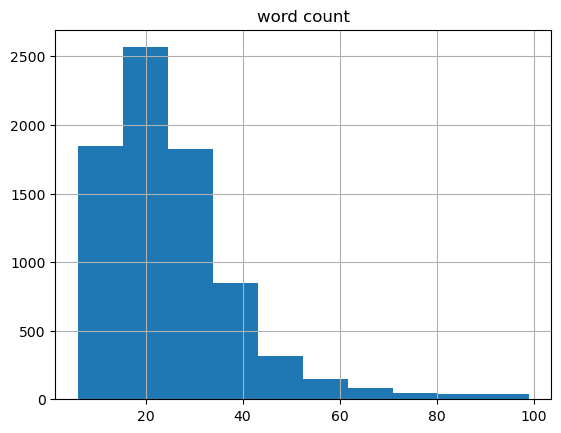

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
df_report.hist(column = 'word count')

In [19]:
df_report

,doc_type,fname,sentence,word count
1,report,coca-cola,We do all of this while staying true to our pu...,19
2,report,coca-cola,The Coca-Cola Company 2021 Business & ESG Repo...,50
3,report,coca-cola,We made important decisions about streamlining...,29
4,report,coca-cola,"Through all of the challenges, initiatives and...",28
5,report,coca-cola,"Our environmental, social and governance (ESG)...",12
...,...,...,...,...
4299,report,unilever,All the pulp is bleached using an elemental ch...,12
4300,report,unilever,Printed in the UK by Pureprint using its purep...,12
4303,report,unilever,Both the manufacturing mill and the printer ar...,24
4304,report,unilever,If you have finished with this document and no...,31


In [21]:
df_report.to_csv(fname_out, index = False)